# DDPG on Reacher x20
## DRL for Continuous Control 

---

This notebook implements **_Deep Deterministic Policy Gradients_** (DDPG) from [Continuous Control with Deep Reinforcement Learning](https://arxiv.org/abs/1509.02971) in pytorch to solve the [Reacher x20](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment from [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), modified for the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

![Trained Reacher x20 Environment](assets/reacher.gif)

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

This environment contains 20 identical agents, each with its own copy of the environment.

To **_solve this environment_**, the agents must get an **average score of +30 over 100 consecutive episodes, and over all agents**. 


## Import the necessary packages from various libraries

In [1]:
import numpy as np
import random
from collections import deque
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from unityagents import UnityEnvironment
import torch

### Install local python scripts.
- [**agent.py**](agent.py): contains the agent class.
- [**model.py**](model.py): contains the noise & layer functions as well as the Actor and Critic network classes.
- [**trainer.py**](trainer.py): contains the build_env and ddpg functions necessary for initializing the Unity class and the training the agents. 
- [**utils.py**](utils.py): contains plotting functions and file related utitlities.

In [2]:
from agent import Agent
from model import *
from trainer import *
import utils

# Load the Unity ML-Agents environment
- These are kept in a parent directory and not uploaded to the repository.
- The provided links are for Reacher single agent and twenty agents
- Linux and OSX are provided for example

In [3]:
# Reacher
# fname = "../unity_envs/Reacher/Reacher_Linux_NoVis/Reacher.x86_64"
# fname = "../unity_envs/Reacher/Reacher_Linux/Reacher.x86_64"
# fname = "../unity_envs/Reacher/Reacher.app"

# Reacher x20 
fname = "../unity_envs/Reacher_x20/Reacher_Linux_NoVis/Reacher.x86_64"
# fname = "../unity_envs/Reacher_x20/Reacher_Linux/Reacher.x86_64"
# fname = "../unity_envs/Reacher_x20.app"

## Experiment and evironment configuration
The next few cells aid in configuring the experiment ID and corresponding save folder as well as parameters for loading the environments.

In [4]:
# env_id = 'Reacher'
env_id = 'Reacher_x20'

In [5]:
seed = 0
logdir='logdir'
exp_id = 1

In [6]:
fp = f'{logdir}/{env_id}_agent_exp{exp_id}/'
env_config = {
    'file_name': fname,
    'no_graphics': True,
    'seed': seed
}
utils.rm_dir(fp)
utils.save_config(env_config, filepath=fp+'/env_config')

### Initialize the Enviroment
The environmental configuration instructs the build_env function for the parameters of the environment, including whether to generate a graphic interface.

The function also outputs the various properties of the environment. 

In [7]:
env, brain_name, num_agents, action_size, state_size = build_env(**env_config)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


# Learning Algorithm

As mentioned previously, the algorithm used here is a variant of the **Deep Deterministic Policy Gradient** (DDPG) algorithm, from [Continuous Control with Deep Reinforcement Learning](https://arxiv.org/abs/1509.02971), shown below. The variation herein is in clipping the critic network prior each learning update. This was done as the original intention for this project was to implement _**Proximal Policy Optimization**_ (PPO) from [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/arXiv:1707.06347), which has been left to future work.

![Deep Deterministic Policy Gradient](assets/ddpg.png)



## Agent configuration
This operates in the same way as the env_config, this time, configuring the agent properties, including networks - in this case, Actor-Critic - including optimizers and clip functions. Agent config is saved to the log directory. 

Both Actor and Critic networks utilize 3 fully-connected layers and the hyperparameters below. The networks are in [_model.py_](model.py), as are the Ornstein-Uhlenbeck noise and layer initialization functions. 

In [ ]:
agent_config = {
    'state_size':state_size,
    'action_size':action_size,
    'num_agents':num_agents,
    'memory_size': int(1e6),
    'batch_size': 256,
    'gamma': 0.99,
    'tau': 1e-3,
    'learning_rate_actor': 3e-4,
    'learning_rate_critic': 1e-4,
    'weight_decay': 0.00001, # L2 weight decay
    'network_actor': Actor,
    'network_layers_actor': [256,256],
    'network_critic': Critic,
    'network_layers_critic':[256,256],
    'optimizer_actor': torch.optim.Adam,
    'optimizer_critic': torch.optim.Adam,
    'clip_critic': True,
    'use_noise': True,
    'filepath': f'{logdir}/{exp_id}/checkpoint',
    'random_seed': 0
}
utils.save_config(agent_config, filepath=fp+'/agent_config')

### Create the agent

In [9]:
agent = Agent(**agent_config)

## Training Configuration
Parameters for the training algorithm, in this case, DDPG.

In [10]:
training_config = {
    'agent': agent,
    'env': env,
    'brain_name': brain_name,
    'n_episodes': int(1e3), 
    'max_t':None, 
    'print_every':1, 
    'checkpoint_freq':200, 
    'checkpoint_dir': fp,
    'reward_window':100, 
    'target_reward': 30.,
    'add_noise':True, 
    'close':True,
}
utils.save_config(training_config, filepath=fp+'/training_config')


### Run the DDPG algorithm and train Actor-Critic Networks 

In [11]:
scores = ddpg(**training_config)

  0%|          | 0/1000 [00:00<?, ?it/s]


Scores from last episode and the average over 100 will update every 1 episodes.



Score: 37.52500 (Avg: 30.05228):  11%|█         | 109/1000 [51:10<7:46:27, 31.41s/it]
Environment solved in 10 episodes!	Average Score: 30.05:  11%|█         | 109/1000 [51:10<7:46:27, 31.41s/it]


Learner saved to logdir/Reacher_x20_agent_exp16/solved-10.
Finished training.


# Plot of Rewards
## Visualize the Agents' scores during training

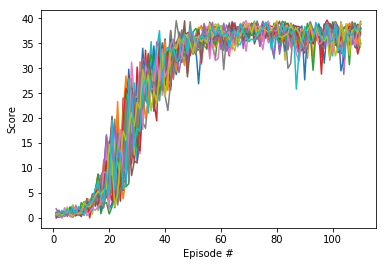

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Save the resulting scores

In [9]:
utils.save_pickle(scores, fp+'scores')

## Load scores from the results

In [ ]:
scores = utils.load_pickle(fp+'scores.pickle')

## Visualize the mean score of all 20 agents

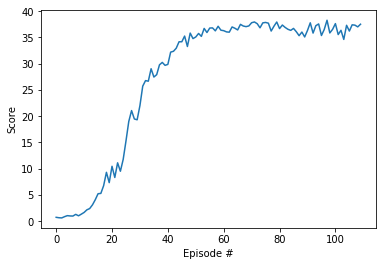

In [10]:
np.array(scores).shape
utils.plot_scores(np.mean(scores, axis=1))

## Results
This method converged reaching the solution incredibly fast; after only 10 episodes the system began to learn the proper actions, managing to retrain its momentum thusly achieving an average score of 30.05228 over 100 episodes by the 109th episode. 

Such a success precluded further exploration of model architectures or algorithms.

# Ideas for Future Work
_Multithreading Agents_ (Actors) and/or _parallelizing training_ environments will also be explored in the future, as a means for accellerating training. 

_**Proximal Policy Optimization**_ (PPO) from [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/arXiv:1707.06347) will be explored in future work, as it was not fully investigated herein.

![PPO](assets/ppo.png)

